In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sys
import time
import numpy as np
from sklearn.metrics import f1_score
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

'''
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
!pip install pytorch-metric-learning

In [3]:
# model.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision

class ResNet(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(ResNet, self).__init__()
        if (name == 'resnet50'):
            self.encoder = torchvision.models.resnet50(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(2048, num_classes)
        else:
            self.encoder = torchvision.models.resnet18(zero_init_residual=True)
            self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            self.encoder.fc = nn.Identity()
            self.fc = nn.Linear(512, num_classes)
    def forward(self, x):

        return self.fc(self.encoder(x))



In [4]:
class Prj_Head(nn.Module):
    def __init__(self,in_dim,feature_dim):
        super(Prj_Head, self).__init__()
        
        self.g1 = nn.Sequential(nn.Linear(in_dim, 1024, bias=False),
                               nn.BatchNorm1d(1024),
                               nn.ReLU(inplace=True)
                               )
        self.g2 = nn.Sequential(nn.Linear(1024, 512, bias=False),
                                nn.BatchNorm1d(512),
                                nn.ReLU(inplace=True)
                                )
        self.g3=nn.Linear(512, feature_dim, bias=True)
    def forward(self, x):
        # print(x.shape)
        x = torch.flatten(x, start_dim=1, end_dim=- 1) 
        x = self.g1(x)
        x = self.g2(x)
        x = self.g3(x)
        return x

In [5]:
class Encdr(nn.Module):
    """encoder + classifier"""
    def __init__(self, name='resnet50', num_classes=2):
        super(Encdr, self).__init__()
        self.encoder = torchvision.models.resnet50(pretrained=True, zero_init_residual=True)
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.encoder.fc = nn.Identity()
        self.fc = nn.Linear(2048, 512)

    def forward(self, x):

        return self.fc(self.encoder(x))
    
    def add_feature(self):
        self.fc1=nn.Linear(512,2)

        

In [6]:
# datasets.py

import torch.utils.data as data
from PIL import Image
import numpy as np
import pandas as pd
import os

class OLIVES(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor




class RECOVERY(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        return image



class RECOVERY_TEST(data.Dataset):
    def __init__(self,df, img_dir, transforms):
        self.img_dir = img_dir
        self.transforms = transforms
        self.df = pd.read_csv(df)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.img_dir + self.df.iloc[idx,0]
        image = Image.open(path).convert("L")
        image = np.array(image)
        image = Image.fromarray(image)
        image = self.transforms(image)
        b1 = self.df.iloc[idx,1]
        b2 = self.df.iloc[idx,2]
        b3 = self.df.iloc[idx,3]
        b4 = self.df.iloc[idx, 4]
        b5 = self.df.iloc[idx, 5]
        b6 = self.df.iloc[idx, 6]
        bio_tensor = torch.tensor([b1, b2, b3, b4, b5, b6])
        return image, bio_tensor


In [7]:
# data_preprocessing.py

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from PIL import Image

def combine_excel(csv_dir):
    filenames = glob.glob(csv_dir + "/*.xlsx")
    outputxlsx = pd.DataFrame()

    for file in filenames:
        df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True, sort=False)
        outputxlsx = outputxlsx.append(df, ignore_index=True)

    outputxlsx.to_csv('test_set_labels.csv',index=False)

def analyze_dataframe(csv_dir):
    pass

def process_images(csv_dir):
    df = pd.read_csv(csv_dir)

    for i in tqdm(range(0,len(df))):
        path = df.iloc[i,0]
        im = Image.open(path).convert('L')


def numpy_submission(sub_dir,np_dir):
    np_file  = np.load(np_dir)
    print(len(np_file))
    sub_dir = pd.read_csv(sub_dir)
    print(len(sub_dir))
    for i in range(0,len(sub_dir)):
        sub_dir.iloc[i,1] = np_file[i,0]
        sub_dir.iloc[i, 2] = np_file[i, 1]
        sub_dir.iloc[i, 3] = np_file[i, 2]
        sub_dir.iloc[i, 4] = np_file[i, 3]
        sub_dir.iloc[i, 5] = np_file[i, 4]
        sub_dir.iloc[i, 6] = np_file[i, 5]
    print(sub_dir.head())
    sub_dir.to_csv('baseline_result.csv',index=False)



    #process_images(csv_dir)

In [8]:
from __future__ import print_function

import math
import numpy as np
import torch.optim as optim
import os
from sklearn.metrics import f1_score
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets
from torch.utils.data import random_split, Subset, SubsetRandomSampler

import torch.nn as nn
def set_model(opt, freeze = False):


    device = opt.device
    model = ResNet(name=opt.model,num_classes = opt.ncls)
    if freeze:
        model.encoder.requires_grad_(False)
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion


# model for self supervised training

def set_model_st(opt,Net):


    device = opt.device
    #model = Encdr(name=opt.model,num_classes = opt.ncls)
    model = nn.Sequential(
    Net,
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 6, bias=True))
    
    criterion = torch.nn.BCEWithLogitsLoss()

    model = model.to(device)
    criterion = criterion.to(device)


    return model, criterion




def set_loader(opt):
    # construct data loader
    if opt.dataset == 'OLIVES' or opt.dataset == 'RECOVERY':
        mean = (.1706)
        std = (.2112)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),

        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


    if opt.dataset =='OLIVES':
        data_path_train = opt.train_image_path
        data_path_test = opt.test_image_path
        train_dataset = OLIVES(csv_path_train,data_path_train,transforms = train_transform)
        unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
        val_dataset = OLIVES(csv_path_valid,data_path_train,transforms = val_transform)
        test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
        
        # Create a random sampler for the subset
        np.random.seed(121)
        random_indices = np.random.choice(len(unlabelled_train_dataset), unlabel_count, replace=False)
        subset_sampler = SubsetRandomSampler(random_indices)

    else:
        raise ValueError(opt.dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(unlabelled_train_dataset,
        sampler=subset_sampler, batch_size=opt.batch_size,
        num_workers=opt.num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader, unlabelled_train_loader




class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res


def adjust_learning_rate(args, optimizer, epoch):
    lr = args.learning_rate
    if args.cosine:
        eta_min = lr * (args.lr_decay_rate ** 3)
        lr = eta_min + (lr - eta_min) * (
                1 + math.cos(math.pi * epoch / args.epochs)) / 2
    else:
        steps = np.sum(epoch > np.asarray(args.lr_decay_epochs))
        if steps > 0:
            lr = lr * (args.lr_decay_rate ** steps)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def warmup_learning_rate(args, epoch, batch_id, total_batches, optimizer):
    if args.warm and epoch <= args.warm_epochs:
        p = (batch_id + (epoch - 1) * total_batches) / \
            (args.warm_epochs * total_batches)
        lr = args.warmup_from + p * (args.warmup_to - args.warmup_from)

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


def set_optimizer(opt, model):

    optimizer = optim.SGD(model.parameters(),
                          lr=opt.learning_rate,
                          momentum=opt.momentum,
                          weight_decay=opt.weight_decay)
    #optimizer = torch.optim.Adam(model.parameters(), lr=opt.learning_rate)

    return optimizer


def save_model(model, optimizer, opt, epoch, save_file):
    print('==> Saving...')
    state = {
        'opt': opt,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch,
    }
    torch.save(state, save_file)
    del state

In [9]:
#----------------------------------------------------------------------------------------------------
# Augmentations
from torchvision import transforms
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""
    """Borrowed from MoCo implementation"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
class FixedRandomRotation:
    """Rotate by one of the given angles."""
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)
    
def torchvision_transforms(eval=False, aug=None):

    trans = []

    if aug["resize"]:
        trans.append(transforms.Resize(aug["resize"]))

    if aug["randcrop"] and aug["scale"] and not eval:
        trans.append(transforms.RandomResizedCrop(aug["randcrop"], scale=aug["scale"]))

    if aug["randcrop"] and eval:
        trans.append(transforms.CenterCrop(aug["randcrop"]))

    if aug["flip"] and not eval:
        trans.append(transforms.RandomHorizontalFlip(p=0.5))
        trans.append(transforms.RandomVerticalFlip(p=0.5))

    if aug["jitter_d"] and not eval:
        trans.append(transforms.RandomApply(
            [transforms.ColorJitter(0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.8*aug["jitter_d"], 0.2*aug["jitter_d"])],
             p=aug["jitter_p"]))

    if aug["gaussian_blur"] and not eval:
        trans.append(transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1,.2))], p=aug["gaussian_blur"]))

    if aug["rotation"] and not eval:
        # rotation_transform = FixedRandomRotation(angles=[0, 90, 180, 270])
        trans.append(FixedRandomRotation(angles=[0, 90, 180, 270]))


    trans = transforms.Compose(trans)
   
    return trans
aug = {"resize":0,
    "randcrop":224,
      "scale": (0.25, 1.0),
      "flip":0,
      "jitter_d":0.3,
       "jitter_p":0.3,
       "gaussian_blur":0.5,
       "rotation":1
      }
augmentations = torchvision_transforms(aug = aug)
print(augmentations)




Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.25, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomApply(
    p=0.3
    ColorJitter(brightness=(0.76, 1.24), contrast=(0.76, 1.24), saturation=(0.76, 1.24), hue=(-0.06, 0.06))
)
    RandomApply(
    p=0.5
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2))
)
)


In [10]:
# config.py

import argparse
import math
import os

def parse_option(string):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10,
                        help='print frequency')
    parser.add_argument('--save_freq', type=int, default=50,
                        help='save frequency')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='batch_size')
    parser.add_argument('--num_workers', type=int, default=8,
                        help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training epochs')
    parser.add_argument('--device', type=str, default='cuda:0')
    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05,
                        help='learning rate')
    parser.add_argument('--patient_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--cluster_lambda', type=float, default=1,
                        help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='100',
                        help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1,
                        help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')
    parser.add_argument('--train_csv_path', type=str, default='train data csv')
    parser.add_argument('--test_csv_path', type=str, default='test data csv')
    parser.add_argument('--train_image_path', type=str, default='train data csv')
    parser.add_argument('--test_image_path', type=str, default='test data csv')

    parser.add_argument('--parallel', type=int, default=1, help='data parallel')
    parser.add_argument('--ncls', type=int, default=6, help='Number of Classes')
    # model dataset
    parser.add_argument('--model', type=str, default='resnet50')
    parser.add_argument('--dataset', type=str, default='TREX_DME',
                        choices=[ 'OLIVES'], help='dataset')
    parser.add_argument('--mean', type=str, help='mean of dataset in path in form of str tuple')
    parser.add_argument('--std', type=str, help='std of dataset in path in form of str tuple')
    parser.add_argument('--data_folder', type=str, default=None, help='path to custom dataset')
    parser.add_argument('--size', type=int, default=128, help='parameter for RandomResizedCrop')

    # temperature
    parser.add_argument('--temp', type=float, default=0.07,
                        help='temperature for loss function')



    opt = parser.parse_args(string)

    # check if dataset is path that passed required arguments
    if opt.dataset == 'path':
        assert opt.data_folder is not None \
               and opt.mean is not None \
               and opt.std is not None

    # set the path according to the environment
    if opt.data_folder is None:
        opt.data_folder = './datasets/'
    opt.model_path = './save/{}_models'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_lr_{}_decay_{}_bsz_{}_temp_{}'. \
        format(opt.model, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp)


    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt

In [11]:
from pytorch_metric_learning.losses import NTXentLoss
ss_loss_func = NTXentLoss(temperature=0.10)

def train_ss(Net,projection_head,data_loader, epoch):
    Net.train()
    projection_head.train()
    total_loss = AverageMeter()
    for idx, x in enumerate(data_loader): 
        # print(batch_idx)
        optimizer.zero_grad()
        x = x.to(device)
        # Get data representations
        
        A1 = augmentations(x)
        A2 = augmentations(x)
        
        h1 = Net(A1)
        z1 = projection_head(h1)
        
        h2 = Net(A2)
        z2 = projection_head(h2)
        
        # Prepare for loss
        embeddings = torch.cat((z1, z2))
        # The same index corresponds to a positive pair
        indices = torch.arange(0, z1.size(0), device=z2.device)
        labels = torch.cat((indices, indices))
        loss = ss_loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        total_loss.update(loss.data.item())
        
        # print info
        if (idx + 1) % 50 == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(data_loader)))
            
        del x, A1, A2
            
    return total_loss.avg

In [12]:
def train_supervised(train_loader, val_loader, model,criterion, optimizer, epoch, opt):
    """one epoch training"""
    model.train()


    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    device = opt.device
    end = time.time()
    correct_predictions = 0

    for idx, (image, bio_tensor) in enumerate(train_loader):
        data_time.update(time.time() - end)

        images = image.to(device)

        labels = bio_tensor.float()

        labels = labels.to(device)
        bsz = labels.shape[0]

        # compute loss
        output = model(images)
        loss = criterion(output, labels)
        
        # Calculate training accuracy
        predicted_labels = torch.round(torch.sigmoid(output)) 
        correct_predictions += (predicted_labels == labels).sum().item()

        # update metric
        losses.update(loss.item(), bsz)

        # SGD
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % 10 == 0:
            print('Train: [{0}][{1}/{2}]\t'.format(
                epoch, idx + 1, len(train_loader)))

            sys.stdout.flush()

    total_values = len(train_loader.dataset) * 6
    training_accuracy = (correct_predictions / total_values) * 100.0
    print(f"Training Accuracy: {training_accuracy:.2f}%")
    print("Training loss:", losses.avg)
    
    return losses.avg


In [13]:
def submission_generate(val_loader, model, opt, epoch = 'final'):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    with torch.no_grad():
        for idx, image in (enumerate(val_loader)):

            images = image.float().to(device)

            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())


    out_submisison = np.array(out_list)
    np.save('output',out_submisison)
    
    output = np.load('/kaggle/working/output.npy')
    submission = pd.read_csv("/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv")
    submission.iloc[:, 1:] = output
    submission.to_csv(f"/kaggle/working/submission{epoch}.csv", index = False)


In [14]:
def sample_evaluation(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print("Validation accuracy:", (correct_count / total_count) * 100, "%")

    label_array = np.array(label_list)
    out_array = np.array(out_list)
    f = f1_score(label_array,out_array,average='macro')
    print("Validation F1:", f)
    
    return f

In [15]:
def sample_evaluation_acc(val_loader, model, opt):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    label_list = []
    correct_count = 0
    total_count = 0

    with torch.no_grad():
        for idx, (image,bio_tensor) in (enumerate(val_loader)):

            images = image.float().to(device)
            labels = bio_tensor.float().to(device)

            labels = labels.float()

            #label_list.append(labels.squeeze().detach().cpu().numpy())
            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            #out_list.append(output.squeeze().detach().cpu().numpy())
            
            correct_count += (labels == output).sum().item()
            total_count += len(labels) * 6
        
    print((correct_count / total_count) * 100, "%")



In [16]:
def load_model(model, load_file, key = 'model'):
    print('==> Loading...')
    checkpoint = torch.load(load_file)
    model.load_state_dict(checkpoint[key])
    return model

In [17]:
if not os.path.isdir('/kaggle/working/supervised'):
    os.makedirs('/kaggle/working/supervised')
if not os.path.isdir('/kaggle/working/unsupervised'):
    os.makedirs('/kaggle/working/unsupervised')

In [18]:
args = args = ['--batch_size', '64', '--model', "resnet50", '--dataset', 'OLIVES', '--epochs', '2', '--device', 'cuda:0', '--train_image_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TRAIN/OLIVES', '--test_image_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/', '--test_csv_path', '/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv', '--train_csv_path', '/kaggle/input/olives-training-labels/Training_Biomarker_Data.csv']
opt = parse_option(args)

# CSV paths
csv_path_train = "/kaggle/input/olives-training-labels/training_split_biomarker_data.csv"
csv_path_valid = "/kaggle/input/olives-training-labels/validation_biomarker_data.csv"
csv_path_test = "/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv"
csv_path_unlabelled = "/kaggle/input/olives-training-labels/unlabelled_images.csv"

In [19]:
# build data loader
unlabel_count = 20000
train_loader, val_loader, test_loader, unlabelled_train_loader = set_loader(opt)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [20]:
##### UNSUPERVISED LEARNING PART

In [21]:
#--------------------------------------------------------------------------
device = torch.device("cuda:0" )
Net = Encdr().to(device)
projection_head = Prj_Head(512,6).to(device)

optimizer = torch.optim.Adam(list(Net.parameters())+list(projection_head.parameters()), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

#train(Net,projection_head,train_loader)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Train: [1][50/313]	
Train: [1][100/313]	
Train: [1][150/313]	
Train: [1][200/313]	
Train: [1][250/313]	
Train: [1][300/313]	
Epoch   1, Loss: 2.6579
==> Saving...
Train: [2][50/313]	
Train: [2][100/313]	
Train: [2][150/313]	
Train: [2][200/313]	
Train: [2][250/313]	
Train: [2][300/313]	
Epoch   2, Loss: 1.5851
==> Saving...
Train: [3][50/313]	
Train: [3][100/313]	
Train: [3][150/313]	
Train: [3][200/313]	
Train: [3][250/313]	
Train: [3][300/313]	
Epoch   3, Loss: 1.4234
==> Saving...
Train: [4][50/313]	
Train: [4][100/313]	
Train: [4][150/313]	
Train: [4][200/313]	
Train: [4][250/313]	
Train: [4][300/313]	
Epoch   4, Loss: 1.2078
==> Saving...
==> Saving...
Train: [5][50/313]	
Train: [5][100/313]	
Train: [5][150/313]	
Train: [5][200/313]	
Train: [5][250/313]	
Train: [5][300/313]	
Epoch   5, Loss: 1.2525
Train: [6][50/313]	
Train: [6][100/313]	
Train: [6][150/313]	
Train: [6][200/313]	
Train: [6][250/313]	
Train: [6][300/313]	
Epoch   6, Loss: 1.0728
==> Saving...
Train: [7][50/313]	
Tr

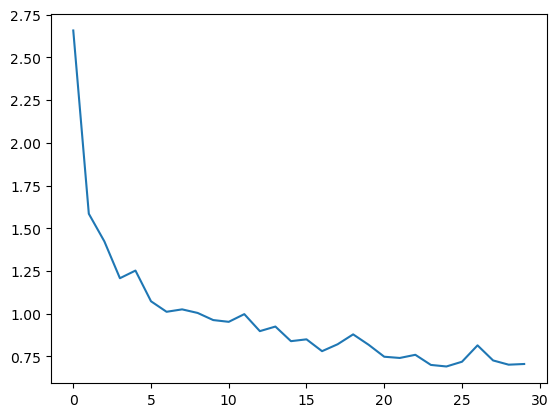

In [22]:
n_epoch = 30
loss_list = []
best_loss = 10000
save_file = os.path.join(opt.save_folder + 'models', 'last.pth')
#save_model(model, optimizer, opt, opt.epochs, save_file)

for epoch in range(1, n_epoch + 1):
    loss = train_ss(Net,projection_head,unlabelled_train_loader, epoch)
    print(f'Epoch {epoch:3d}, Loss: {loss:.4f}')
    scheduler.step()
    loss_list.append(loss)
    if loss<best_loss:
        best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_best_loss.pth.tar') 
        save_model(Net, optimizer, opt, opt.epochs, '/kaggle/working/unsupervised/best_loss.pth')
    if epoch % 4== 0:
        #best_loss = loss
        #torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_checkpoint.pth.tar') 
        save_model(Net, optimizer, opt, opt.epochs, f'/kaggle/working/unsupervised/epoch{epoch}.pth')
#torch.save(Net, f'./model_checkpoints/simclr_ki67/resnet50_ki67_dapi_chan_pretraining_final_checkpoint.pth.tar') 
plt.figure()
plt.plot(loss_list)

In [23]:
###### SUPERVISED LEARNING PART

In [24]:
# If loading pretrained
load_file = "/kaggle/working/unsupervised/epoch24.pth"  # change to model path
device = torch.device("cuda:0" )
Net = Encdr().to(device)
Net = load_model(Net, load_file, "model")

==> Loading...


In [25]:
#Net.add_feature()
model, criterion = set_model_st(opt, Net)    
optimizer = set_optimizer(opt, model)

In [26]:
# To check performance without the pre training
#model, criterion = set_model(opt)    
#optimizer = set_optimizer(opt, model)

In [27]:
# training routine with freezing
#model[0].requires_grad_(False)
#opt.learning_rate = 0.05
#for epoch in range(1, 15+1):
#    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)

In [28]:
# training routine without freezing
model[0].requires_grad_(True)
opt.learning_rate = 0.05

best_f1 = 0.6
for epoch in range(1, 70+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 5 == 0:
        submission_generate(test_loader, model, opt, epoch)
    

Train: [1][10/140]	
Train: [1][20/140]	
Train: [1][30/140]	
Train: [1][40/140]	
Train: [1][50/140]	
Train: [1][60/140]	
Train: [1][70/140]	
Train: [1][80/140]	
Train: [1][90/140]	
Train: [1][100/140]	
Train: [1][110/140]	
Train: [1][120/140]	
Train: [1][130/140]	
Train: [1][140/140]	
Training Accuracy: 68.16%
Training loss: 0.5860223341587013
Validation accuracy: 68.02721088435374 %
Validation F1: 0.27898782303941044


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [2][10/140]	
Train: [2][20/140]	
Train: [2][30/140]	
Train: [2][40/140]	
Train: [2][50/140]	
Train: [2][60/140]	
Train: [2][70/140]	
Train: [2][80/140]	
Train: [2][90/140]	
Train: [2][100/140]	
Train: [2][110/140]	
Train: [2][120/140]	
Train: [2][130/140]	
Train: [2][140/140]	
Training Accuracy: 71.21%
Training loss: 0.5409425560750082
Validation accuracy: 68.29931972789116 %
Validation F1: 0.3698266784329085


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [3][10/140]	
Train: [3][20/140]	
Train: [3][30/140]	
Train: [3][40/140]	
Train: [3][50/140]	
Train: [3][60/140]	
Train: [3][70/140]	
Train: [3][80/140]	
Train: [3][90/140]	
Train: [3][100/140]	
Train: [3][110/140]	
Train: [3][120/140]	
Train: [3][130/140]	
Train: [3][140/140]	
Training Accuracy: 73.76%
Training loss: 0.5098244931350832
Validation accuracy: 71.25850340136054 %
Validation F1: 0.3938666601293351


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [4][10/140]	
Train: [4][20/140]	
Train: [4][30/140]	
Train: [4][40/140]	
Train: [4][50/140]	
Train: [4][60/140]	
Train: [4][70/140]	
Train: [4][80/140]	
Train: [4][90/140]	
Train: [4][100/140]	
Train: [4][110/140]	
Train: [4][120/140]	
Train: [4][130/140]	
Train: [4][140/140]	
Training Accuracy: 76.49%
Training loss: 0.47608217800858577
Validation accuracy: 72.82312925170068 %
Validation F1: 0.4564998483605753


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [5][10/140]	
Train: [5][20/140]	
Train: [5][30/140]	
Train: [5][40/140]	
Train: [5][50/140]	
Train: [5][60/140]	
Train: [5][70/140]	
Train: [5][80/140]	
Train: [5][90/140]	
Train: [5][100/140]	
Train: [5][110/140]	
Train: [5][120/140]	
Train: [5][130/140]	
Train: [5][140/140]	
Training Accuracy: 77.77%
Training loss: 0.45773517729242064
Validation accuracy: 73.77551020408163 %
Validation F1: 0.36103279461146465


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [6][10/140]	
Train: [6][20/140]	
Train: [6][30/140]	
Train: [6][40/140]	
Train: [6][50/140]	
Train: [6][60/140]	
Train: [6][70/140]	
Train: [6][80/140]	
Train: [6][90/140]	
Train: [6][100/140]	
Train: [6][110/140]	
Train: [6][120/140]	
Train: [6][130/140]	
Train: [6][140/140]	
Training Accuracy: 78.68%
Training loss: 0.4461055581787291
Validation accuracy: 74.6938775510204 %
Validation F1: 0.43997908961312837


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [7][10/140]	
Train: [7][20/140]	
Train: [7][30/140]	
Train: [7][40/140]	
Train: [7][50/140]	
Train: [7][60/140]	
Train: [7][70/140]	
Train: [7][80/140]	
Train: [7][90/140]	
Train: [7][100/140]	
Train: [7][110/140]	
Train: [7][120/140]	
Train: [7][130/140]	
Train: [7][140/140]	
Training Accuracy: 79.30%
Training loss: 0.43501173474110144
Validation accuracy: 74.6938775510204 %
Validation F1: 0.41779151332554215


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [8][10/140]	
Train: [8][20/140]	
Train: [8][30/140]	
Train: [8][40/140]	
Train: [8][50/140]	
Train: [8][60/140]	
Train: [8][70/140]	
Train: [8][80/140]	
Train: [8][90/140]	
Train: [8][100/140]	
Train: [8][110/140]	
Train: [8][120/140]	
Train: [8][130/140]	
Train: [8][140/140]	
Training Accuracy: 79.58%
Training loss: 0.43127147216758377
Validation accuracy: 73.9795918367347 %
Validation F1: 0.43216802085866496


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [9][10/140]	
Train: [9][20/140]	
Train: [9][30/140]	
Train: [9][40/140]	
Train: [9][50/140]	
Train: [9][60/140]	
Train: [9][70/140]	
Train: [9][80/140]	
Train: [9][90/140]	
Train: [9][100/140]	
Train: [9][110/140]	
Train: [9][120/140]	
Train: [9][130/140]	
Train: [9][140/140]	
Training Accuracy: 80.31%
Training loss: 0.4187466313042804
Validation accuracy: 75.20408163265306 %
Validation F1: 0.45729886791850544


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [10][10/140]	
Train: [10][20/140]	
Train: [10][30/140]	
Train: [10][40/140]	
Train: [10][50/140]	
Train: [10][60/140]	
Train: [10][70/140]	
Train: [10][80/140]	
Train: [10][90/140]	
Train: [10][100/140]	
Train: [10][110/140]	
Train: [10][120/140]	
Train: [10][130/140]	
Train: [10][140/140]	
Training Accuracy: 80.52%
Training loss: 0.41594977443275444
Validation accuracy: 73.46938775510205 %
Validation F1: 0.49505319624542493


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [11][10/140]	
Train: [11][20/140]	
Train: [11][30/140]	
Train: [11][40/140]	
Train: [11][50/140]	
Train: [11][60/140]	
Train: [11][70/140]	
Train: [11][80/140]	
Train: [11][90/140]	
Train: [11][100/140]	
Train: [11][110/140]	
Train: [11][120/140]	
Train: [11][130/140]	
Train: [11][140/140]	
Training Accuracy: 80.82%
Training loss: 0.4100405467775644
Validation accuracy: 76.12244897959184 %
Validation F1: 0.4801457813491898


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [12][10/140]	
Train: [12][20/140]	
Train: [12][30/140]	
Train: [12][40/140]	
Train: [12][50/140]	
Train: [12][60/140]	
Train: [12][70/140]	
Train: [12][80/140]	
Train: [12][90/140]	
Train: [12][100/140]	
Train: [12][110/140]	
Train: [12][120/140]	
Train: [12][130/140]	
Train: [12][140/140]	
Training Accuracy: 81.43%
Training loss: 0.4033746661546921
Validation accuracy: 76.25850340136054 %
Validation F1: 0.4645458337693594


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [13][10/140]	
Train: [13][20/140]	
Train: [13][30/140]	
Train: [13][40/140]	
Train: [13][50/140]	
Train: [13][60/140]	
Train: [13][70/140]	
Train: [13][80/140]	
Train: [13][90/140]	
Train: [13][100/140]	
Train: [13][110/140]	
Train: [13][120/140]	
Train: [13][130/140]	
Train: [13][140/140]	
Training Accuracy: 81.29%
Training loss: 0.40169693499863696
Validation accuracy: 75.17006802721087 %
Validation F1: 0.45435348249037794


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [14][10/140]	
Train: [14][20/140]	
Train: [14][30/140]	
Train: [14][40/140]	
Train: [14][50/140]	
Train: [14][60/140]	
Train: [14][70/140]	
Train: [14][80/140]	
Train: [14][90/140]	
Train: [14][100/140]	
Train: [14][110/140]	
Train: [14][120/140]	
Train: [14][130/140]	
Train: [14][140/140]	
Training Accuracy: 81.69%
Training loss: 0.39380232868480103
Validation accuracy: 76.93877551020408 %
Validation F1: 0.5196069705979501


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [15][10/140]	
Train: [15][20/140]	
Train: [15][30/140]	
Train: [15][40/140]	
Train: [15][50/140]	
Train: [15][60/140]	
Train: [15][70/140]	
Train: [15][80/140]	
Train: [15][90/140]	
Train: [15][100/140]	
Train: [15][110/140]	
Train: [15][120/140]	
Train: [15][130/140]	
Train: [15][140/140]	
Training Accuracy: 81.90%
Training loss: 0.3910023503892757
Validation accuracy: 79.8639455782313 %
Validation F1: 0.5809205996226044


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [16][10/140]	
Train: [16][20/140]	
Train: [16][30/140]	
Train: [16][40/140]	
Train: [16][50/140]	
Train: [16][60/140]	
Train: [16][70/140]	
Train: [16][80/140]	
Train: [16][90/140]	
Train: [16][100/140]	
Train: [16][110/140]	
Train: [16][120/140]	
Train: [16][130/140]	
Train: [16][140/140]	
Training Accuracy: 82.52%
Training loss: 0.3833734630990333
Validation accuracy: 76.97278911564625 %
Validation F1: 0.5411326888558488


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [17][10/140]	
Train: [17][20/140]	
Train: [17][30/140]	
Train: [17][40/140]	
Train: [17][50/140]	
Train: [17][60/140]	
Train: [17][70/140]	
Train: [17][80/140]	
Train: [17][90/140]	
Train: [17][100/140]	
Train: [17][110/140]	
Train: [17][120/140]	
Train: [17][130/140]	
Train: [17][140/140]	
Training Accuracy: 82.64%
Training loss: 0.3785826244491129
Validation accuracy: 78.91156462585033 %
Validation F1: 0.5624585358964621


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [18][10/140]	
Train: [18][20/140]	
Train: [18][30/140]	
Train: [18][40/140]	
Train: [18][50/140]	
Train: [18][60/140]	
Train: [18][70/140]	
Train: [18][80/140]	
Train: [18][90/140]	
Train: [18][100/140]	
Train: [18][110/140]	
Train: [18][120/140]	
Train: [18][130/140]	
Train: [18][140/140]	
Training Accuracy: 82.88%
Training loss: 0.376049109246063
Validation accuracy: 77.17687074829932 %
Validation F1: 0.5435799085780356


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [19][10/140]	
Train: [19][20/140]	
Train: [19][30/140]	
Train: [19][40/140]	
Train: [19][50/140]	
Train: [19][60/140]	
Train: [19][70/140]	
Train: [19][80/140]	
Train: [19][90/140]	
Train: [19][100/140]	
Train: [19][110/140]	
Train: [19][120/140]	
Train: [19][130/140]	
Train: [19][140/140]	
Training Accuracy: 83.47%
Training loss: 0.3700548129168346
Validation accuracy: 78.91156462585033 %
Validation F1: 0.5734037878803012


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [20][10/140]	
Train: [20][20/140]	
Train: [20][30/140]	
Train: [20][40/140]	
Train: [20][50/140]	
Train: [20][60/140]	
Train: [20][70/140]	
Train: [20][80/140]	
Train: [20][90/140]	
Train: [20][100/140]	
Train: [20][110/140]	
Train: [20][120/140]	
Train: [20][130/140]	
Train: [20][140/140]	
Training Accuracy: 83.22%
Training loss: 0.3707058770115479
Validation accuracy: 78.77551020408163 %
Validation F1: 0.5847858493196416


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [21][10/140]	
Train: [21][20/140]	
Train: [21][30/140]	
Train: [21][40/140]	
Train: [21][50/140]	
Train: [21][60/140]	
Train: [21][70/140]	
Train: [21][80/140]	
Train: [21][90/140]	
Train: [21][100/140]	
Train: [21][110/140]	
Train: [21][120/140]	
Train: [21][130/140]	
Train: [21][140/140]	
Training Accuracy: 83.59%
Training loss: 0.36386184314490166
Validation accuracy: 79.72789115646258 %
Validation F1: 0.5590655048545575


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [22][10/140]	
Train: [22][20/140]	
Train: [22][30/140]	
Train: [22][40/140]	
Train: [22][50/140]	
Train: [22][60/140]	
Train: [22][70/140]	
Train: [22][80/140]	
Train: [22][90/140]	
Train: [22][100/140]	
Train: [22][110/140]	
Train: [22][120/140]	
Train: [22][130/140]	
Train: [22][140/140]	
Training Accuracy: 83.45%
Training loss: 0.3636669765194587
Validation accuracy: 79.96598639455782 %
Validation F1: 0.5627422326812681


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [23][10/140]	
Train: [23][20/140]	
Train: [23][30/140]	
Train: [23][40/140]	
Train: [23][50/140]	
Train: [23][60/140]	
Train: [23][70/140]	
Train: [23][80/140]	
Train: [23][90/140]	
Train: [23][100/140]	
Train: [23][110/140]	
Train: [23][120/140]	
Train: [23][130/140]	
Train: [23][140/140]	
Training Accuracy: 83.77%
Training loss: 0.357965206887375
Validation accuracy: 79.28571428571428 %
Validation F1: 0.5592973662591157


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [24][10/140]	
Train: [24][20/140]	
Train: [24][30/140]	
Train: [24][40/140]	
Train: [24][50/140]	
Train: [24][60/140]	
Train: [24][70/140]	
Train: [24][80/140]	
Train: [24][90/140]	
Train: [24][100/140]	
Train: [24][110/140]	
Train: [24][120/140]	
Train: [24][130/140]	
Train: [24][140/140]	
Training Accuracy: 84.07%
Training loss: 0.3560650756832836
Validation accuracy: 80.10204081632652 %
Validation F1: 0.5697530537759489


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [25][10/140]	
Train: [25][20/140]	
Train: [25][30/140]	
Train: [25][40/140]	
Train: [25][50/140]	
Train: [25][60/140]	
Train: [25][70/140]	
Train: [25][80/140]	
Train: [25][90/140]	
Train: [25][100/140]	
Train: [25][110/140]	
Train: [25][120/140]	
Train: [25][130/140]	
Train: [25][140/140]	
Training Accuracy: 84.17%
Training loss: 0.3546325814218686
Validation accuracy: 80.74829931972789 %
Validation F1: 0.610553346425061


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [26][10/140]	
Train: [26][20/140]	
Train: [26][30/140]	
Train: [26][40/140]	
Train: [26][50/140]	
Train: [26][60/140]	
Train: [26][70/140]	
Train: [26][80/140]	
Train: [26][90/140]	
Train: [26][100/140]	
Train: [26][110/140]	
Train: [26][120/140]	
Train: [26][130/140]	
Train: [26][140/140]	
Training Accuracy: 84.55%
Training loss: 0.34669760684978806
Validation accuracy: 79.76190476190477 %
Validation F1: 0.5936591567748334


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [27][10/140]	
Train: [27][20/140]	
Train: [27][30/140]	
Train: [27][40/140]	
Train: [27][50/140]	
Train: [27][60/140]	
Train: [27][70/140]	
Train: [27][80/140]	
Train: [27][90/140]	
Train: [27][100/140]	
Train: [27][110/140]	
Train: [27][120/140]	
Train: [27][130/140]	
Train: [27][140/140]	
Training Accuracy: 84.60%
Training loss: 0.34577582007594426
Validation accuracy: 80.78231292517006 %
Validation F1: 0.6188093513228702


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [28][10/140]	
Train: [28][20/140]	
Train: [28][30/140]	
Train: [28][40/140]	
Train: [28][50/140]	
Train: [28][60/140]	
Train: [28][70/140]	
Train: [28][80/140]	
Train: [28][90/140]	
Train: [28][100/140]	
Train: [28][110/140]	
Train: [28][120/140]	
Train: [28][130/140]	
Train: [28][140/140]	
Training Accuracy: 84.84%
Training loss: 0.3421067334686488
Validation accuracy: 76.73469387755102 %
Validation F1: 0.5558902683381334


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [29][10/140]	
Train: [29][20/140]	
Train: [29][30/140]	
Train: [29][40/140]	
Train: [29][50/140]	
Train: [29][60/140]	
Train: [29][70/140]	
Train: [29][80/140]	
Train: [29][90/140]	
Train: [29][100/140]	
Train: [29][110/140]	
Train: [29][120/140]	
Train: [29][130/140]	
Train: [29][140/140]	
Training Accuracy: 84.77%
Training loss: 0.3426343949286492
Validation accuracy: 80.98639455782313 %
Validation F1: 0.5835172816023587


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [30][10/140]	
Train: [30][20/140]	
Train: [30][30/140]	
Train: [30][40/140]	
Train: [30][50/140]	
Train: [30][60/140]	
Train: [30][70/140]	
Train: [30][80/140]	
Train: [30][90/140]	
Train: [30][100/140]	
Train: [30][110/140]	
Train: [30][120/140]	
Train: [30][130/140]	
Train: [30][140/140]	
Training Accuracy: 84.91%
Training loss: 0.3369261040752259
Validation accuracy: 80.4421768707483 %
Validation F1: 0.5724832020149501


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [31][10/140]	
Train: [31][20/140]	
Train: [31][30/140]	
Train: [31][40/140]	
Train: [31][50/140]	
Train: [31][60/140]	
Train: [31][70/140]	
Train: [31][80/140]	
Train: [31][90/140]	
Train: [31][100/140]	
Train: [31][110/140]	
Train: [31][120/140]	
Train: [31][130/140]	
Train: [31][140/140]	
Training Accuracy: 84.94%
Training loss: 0.3349676586756072
Validation accuracy: 81.0204081632653 %
Validation F1: 0.6170651646934325


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [32][10/140]	
Train: [32][20/140]	
Train: [32][30/140]	
Train: [32][40/140]	
Train: [32][50/140]	
Train: [32][60/140]	
Train: [32][70/140]	
Train: [32][80/140]	
Train: [32][90/140]	
Train: [32][100/140]	
Train: [32][110/140]	
Train: [32][120/140]	
Train: [32][130/140]	
Train: [32][140/140]	
Training Accuracy: 84.95%
Training loss: 0.3376141561938391
Validation accuracy: 79.28571428571428 %
Validation F1: 0.5919390577584915


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [33][10/140]	
Train: [33][20/140]	
Train: [33][30/140]	
Train: [33][40/140]	
Train: [33][50/140]	
Train: [33][60/140]	
Train: [33][70/140]	
Train: [33][80/140]	
Train: [33][90/140]	
Train: [33][100/140]	
Train: [33][110/140]	
Train: [33][120/140]	
Train: [33][130/140]	
Train: [33][140/140]	
Training Accuracy: 84.99%
Training loss: 0.3358092545781282
Validation accuracy: 80.78231292517006 %
Validation F1: 0.6174684412181087


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [34][10/140]	
Train: [34][20/140]	
Train: [34][30/140]	
Train: [34][40/140]	
Train: [34][50/140]	
Train: [34][60/140]	
Train: [34][70/140]	
Train: [34][80/140]	
Train: [34][90/140]	
Train: [34][100/140]	
Train: [34][110/140]	
Train: [34][120/140]	
Train: [34][130/140]	
Train: [34][140/140]	
Training Accuracy: 85.13%
Training loss: 0.332329569255378
Validation accuracy: 80.06802721088435 %
Validation F1: 0.5669959299493182


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [35][10/140]	
Train: [35][20/140]	
Train: [35][30/140]	
Train: [35][40/140]	
Train: [35][50/140]	
Train: [35][60/140]	
Train: [35][70/140]	
Train: [35][80/140]	
Train: [35][90/140]	
Train: [35][100/140]	
Train: [35][110/140]	
Train: [35][120/140]	
Train: [35][130/140]	
Train: [35][140/140]	
Training Accuracy: 85.51%
Training loss: 0.32725054313714635
Validation accuracy: 75.27210884353741 %
Validation F1: 0.5360946478450102


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [36][10/140]	
Train: [36][20/140]	
Train: [36][30/140]	
Train: [36][40/140]	
Train: [36][50/140]	
Train: [36][60/140]	
Train: [36][70/140]	
Train: [36][80/140]	
Train: [36][90/140]	
Train: [36][100/140]	
Train: [36][110/140]	
Train: [36][120/140]	
Train: [36][130/140]	
Train: [36][140/140]	
Training Accuracy: 85.33%
Training loss: 0.32757117157293614
Validation accuracy: 79.96598639455782 %
Validation F1: 0.6082211270446737


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [37][10/140]	
Train: [37][20/140]	
Train: [37][30/140]	
Train: [37][40/140]	
Train: [37][50/140]	
Train: [37][60/140]	
Train: [37][70/140]	
Train: [37][80/140]	
Train: [37][90/140]	
Train: [37][100/140]	
Train: [37][110/140]	
Train: [37][120/140]	
Train: [37][130/140]	
Train: [37][140/140]	
Training Accuracy: 85.42%
Training loss: 0.32635937267206366
Validation accuracy: 80.40816326530611 %
Validation F1: 0.613694488121688


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [38][10/140]	
Train: [38][20/140]	
Train: [38][30/140]	
Train: [38][40/140]	
Train: [38][50/140]	
Train: [38][60/140]	
Train: [38][70/140]	
Train: [38][80/140]	
Train: [38][90/140]	
Train: [38][100/140]	
Train: [38][110/140]	
Train: [38][120/140]	
Train: [38][130/140]	
Train: [38][140/140]	
Training Accuracy: 85.46%
Training loss: 0.3267691706055134
Validation accuracy: 81.0204081632653 %
Validation F1: 0.5958453330423982


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [39][10/140]	
Train: [39][20/140]	
Train: [39][30/140]	
Train: [39][40/140]	
Train: [39][50/140]	
Train: [39][60/140]	
Train: [39][70/140]	
Train: [39][80/140]	
Train: [39][90/140]	
Train: [39][100/140]	
Train: [39][110/140]	
Train: [39][120/140]	
Train: [39][130/140]	
Train: [39][140/140]	
Training Accuracy: 85.82%
Training loss: 0.3226420711270628
Validation accuracy: 82.10884353741497 %
Validation F1: 0.6182350412145899


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [40][10/140]	
Train: [40][20/140]	
Train: [40][30/140]	
Train: [40][40/140]	
Train: [40][50/140]	
Train: [40][60/140]	
Train: [40][70/140]	
Train: [40][80/140]	
Train: [40][90/140]	
Train: [40][100/140]	
Train: [40][110/140]	
Train: [40][120/140]	
Train: [40][130/140]	
Train: [40][140/140]	
Training Accuracy: 85.55%
Training loss: 0.3228537981607476
Validation accuracy: 81.83673469387756 %
Validation F1: 0.576046661717507


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [41][10/140]	
Train: [41][20/140]	
Train: [41][30/140]	
Train: [41][40/140]	
Train: [41][50/140]	
Train: [41][60/140]	
Train: [41][70/140]	
Train: [41][80/140]	
Train: [41][90/140]	
Train: [41][100/140]	
Train: [41][110/140]	
Train: [41][120/140]	
Train: [41][130/140]	
Train: [41][140/140]	
Training Accuracy: 85.93%
Training loss: 0.31785076976918564
Validation accuracy: 81.59863945578232 %
Validation F1: 0.6061063959832217


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [42][10/140]	
Train: [42][20/140]	
Train: [42][30/140]	
Train: [42][40/140]	
Train: [42][50/140]	
Train: [42][60/140]	
Train: [42][70/140]	
Train: [42][80/140]	
Train: [42][90/140]	
Train: [42][100/140]	
Train: [42][110/140]	
Train: [42][120/140]	
Train: [42][130/140]	
Train: [42][140/140]	
Training Accuracy: 85.80%
Training loss: 0.3192584889369258
Validation accuracy: 74.59183673469387 %
Validation F1: 0.5817148107710916


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [43][10/140]	
Train: [43][20/140]	
Train: [43][30/140]	
Train: [43][40/140]	
Train: [43][50/140]	
Train: [43][60/140]	
Train: [43][70/140]	
Train: [43][80/140]	
Train: [43][90/140]	
Train: [43][100/140]	
Train: [43][110/140]	
Train: [43][120/140]	
Train: [43][130/140]	
Train: [43][140/140]	
Training Accuracy: 86.24%
Training loss: 0.3132784460780064
Validation accuracy: 79.38775510204081 %
Validation F1: 0.5849517636733469


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [44][10/140]	
Train: [44][20/140]	
Train: [44][30/140]	
Train: [44][40/140]	
Train: [44][50/140]	
Train: [44][60/140]	
Train: [44][70/140]	
Train: [44][80/140]	
Train: [44][90/140]	
Train: [44][100/140]	
Train: [44][110/140]	
Train: [44][120/140]	
Train: [44][130/140]	
Train: [44][140/140]	
Training Accuracy: 86.11%
Training loss: 0.3118052865042497
Validation accuracy: 81.3265306122449 %
Validation F1: 0.5975019414794275


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [45][10/140]	
Train: [45][20/140]	
Train: [45][30/140]	
Train: [45][40/140]	
Train: [45][50/140]	
Train: [45][60/140]	
Train: [45][70/140]	
Train: [45][80/140]	
Train: [45][90/140]	
Train: [45][100/140]	
Train: [45][110/140]	
Train: [45][120/140]	
Train: [45][130/140]	
Train: [45][140/140]	
Training Accuracy: 86.11%
Training loss: 0.30969492423077233
Validation accuracy: 81.39455782312925 %
Validation F1: 0.5716431233789991


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [46][10/140]	
Train: [46][20/140]	
Train: [46][30/140]	
Train: [46][40/140]	
Train: [46][50/140]	
Train: [46][60/140]	
Train: [46][70/140]	
Train: [46][80/140]	
Train: [46][90/140]	
Train: [46][100/140]	
Train: [46][110/140]	
Train: [46][120/140]	
Train: [46][130/140]	
Train: [46][140/140]	
Training Accuracy: 86.10%
Training loss: 0.3100716263209525
Validation accuracy: 79.1156462585034 %
Validation F1: 0.6017936406346622


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [47][10/140]	
Train: [47][20/140]	
Train: [47][30/140]	
Train: [47][40/140]	
Train: [47][50/140]	
Train: [47][60/140]	
Train: [47][70/140]	
Train: [47][80/140]	
Train: [47][90/140]	
Train: [47][100/140]	
Train: [47][110/140]	
Train: [47][120/140]	
Train: [47][130/140]	
Train: [47][140/140]	
Training Accuracy: 86.13%
Training loss: 0.31495283654009343
Validation accuracy: 79.62585034013605 %
Validation F1: 0.6020234605062873


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [48][10/140]	
Train: [48][20/140]	
Train: [48][30/140]	
Train: [48][40/140]	
Train: [48][50/140]	
Train: [48][60/140]	
Train: [48][70/140]	
Train: [48][80/140]	
Train: [48][90/140]	
Train: [48][100/140]	
Train: [48][110/140]	
Train: [48][120/140]	
Train: [48][130/140]	
Train: [48][140/140]	
Training Accuracy: 86.61%
Training loss: 0.30538203452809237
Validation accuracy: 79.8639455782313 %
Validation F1: 0.5955804648442978


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [49][10/140]	
Train: [49][20/140]	
Train: [49][30/140]	
Train: [49][40/140]	
Train: [49][50/140]	
Train: [49][60/140]	
Train: [49][70/140]	
Train: [49][80/140]	
Train: [49][90/140]	
Train: [49][100/140]	
Train: [49][110/140]	
Train: [49][120/140]	
Train: [49][130/140]	
Train: [49][140/140]	
Training Accuracy: 86.45%
Training loss: 0.30502138346480423
Validation accuracy: 77.38095238095238 %
Validation F1: 0.5985357074094068


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [50][10/140]	
Train: [50][20/140]	
Train: [50][30/140]	
Train: [50][40/140]	
Train: [50][50/140]	
Train: [50][60/140]	
Train: [50][70/140]	
Train: [50][80/140]	
Train: [50][90/140]	
Train: [50][100/140]	
Train: [50][110/140]	
Train: [50][120/140]	
Train: [50][130/140]	
Train: [50][140/140]	
Training Accuracy: 86.42%
Training loss: 0.3040872441663633
Validation accuracy: 82.27891156462584 %
Validation F1: 0.5969635706503548


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [51][10/140]	
Train: [51][20/140]	
Train: [51][30/140]	
Train: [51][40/140]	
Train: [51][50/140]	
Train: [51][60/140]	
Train: [51][70/140]	
Train: [51][80/140]	
Train: [51][90/140]	
Train: [51][100/140]	
Train: [51][110/140]	
Train: [51][120/140]	
Train: [51][130/140]	
Train: [51][140/140]	
Training Accuracy: 86.66%
Training loss: 0.3014512643949898
Validation accuracy: 79.93197278911565 %
Validation F1: 0.6215747455604066


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [52][10/140]	
Train: [52][20/140]	
Train: [52][30/140]	
Train: [52][40/140]	
Train: [52][50/140]	
Train: [52][60/140]	
Train: [52][70/140]	
Train: [52][80/140]	
Train: [52][90/140]	
Train: [52][100/140]	
Train: [52][110/140]	
Train: [52][120/140]	
Train: [52][130/140]	
Train: [52][140/140]	
Training Accuracy: 86.69%
Training loss: 0.3012342557735469
Validation accuracy: 81.7687074829932 %
Validation F1: 0.627294470406001


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [53][10/140]	
Train: [53][20/140]	
Train: [53][30/140]	
Train: [53][40/140]	
Train: [53][50/140]	
Train: [53][60/140]	
Train: [53][70/140]	
Train: [53][80/140]	
Train: [53][90/140]	
Train: [53][100/140]	
Train: [53][110/140]	
Train: [53][120/140]	
Train: [53][130/140]	
Train: [53][140/140]	
Training Accuracy: 86.73%
Training loss: 0.30107558177281557
Validation accuracy: 80.10204081632652 %
Validation F1: 0.6184088499042762


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [54][10/140]	
Train: [54][20/140]	
Train: [54][30/140]	
Train: [54][40/140]	
Train: [54][50/140]	
Train: [54][60/140]	
Train: [54][70/140]	
Train: [54][80/140]	
Train: [54][90/140]	
Train: [54][100/140]	
Train: [54][110/140]	
Train: [54][120/140]	
Train: [54][130/140]	
Train: [54][140/140]	
Training Accuracy: 86.86%
Training loss: 0.29960080905061154
Validation accuracy: 79.96598639455782 %
Validation F1: 0.6079277069350189


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [55][10/140]	
Train: [55][20/140]	
Train: [55][30/140]	
Train: [55][40/140]	
Train: [55][50/140]	
Train: [55][60/140]	
Train: [55][70/140]	
Train: [55][80/140]	
Train: [55][90/140]	
Train: [55][100/140]	
Train: [55][110/140]	
Train: [55][120/140]	
Train: [55][130/140]	
Train: [55][140/140]	
Training Accuracy: 86.78%
Training loss: 0.29962265960676676
Validation accuracy: 80.34013605442178 %
Validation F1: 0.6046027881493586


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [56][10/140]	
Train: [56][20/140]	
Train: [56][30/140]	
Train: [56][40/140]	
Train: [56][50/140]	
Train: [56][60/140]	
Train: [56][70/140]	
Train: [56][80/140]	
Train: [56][90/140]	
Train: [56][100/140]	
Train: [56][110/140]	
Train: [56][120/140]	
Train: [56][130/140]	
Train: [56][140/140]	
Training Accuracy: 86.75%
Training loss: 0.2980807307430061
Validation accuracy: 78.9795918367347 %
Validation F1: 0.5943155264312607


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [57][10/140]	
Train: [57][20/140]	
Train: [57][30/140]	
Train: [57][40/140]	
Train: [57][50/140]	
Train: [57][60/140]	
Train: [57][70/140]	
Train: [57][80/140]	
Train: [57][90/140]	
Train: [57][100/140]	
Train: [57][110/140]	
Train: [57][120/140]	
Train: [57][130/140]	
Train: [57][140/140]	
Training Accuracy: 87.14%
Training loss: 0.2933410895488326
Validation accuracy: 79.8639455782313 %
Validation F1: 0.6227424861410453


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [58][10/140]	
Train: [58][20/140]	
Train: [58][30/140]	
Train: [58][40/140]	
Train: [58][50/140]	
Train: [58][60/140]	
Train: [58][70/140]	
Train: [58][80/140]	
Train: [58][90/140]	
Train: [58][100/140]	
Train: [58][110/140]	
Train: [58][120/140]	
Train: [58][130/140]	
Train: [58][140/140]	
Training Accuracy: 86.82%
Training loss: 0.2963527474509785
Validation accuracy: 80.1360544217687 %
Validation F1: 0.5737937151893163


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [59][10/140]	
Train: [59][20/140]	
Train: [59][30/140]	
Train: [59][40/140]	
Train: [59][50/140]	
Train: [59][60/140]	
Train: [59][70/140]	
Train: [59][80/140]	
Train: [59][90/140]	
Train: [59][100/140]	
Train: [59][110/140]	
Train: [59][120/140]	
Train: [59][130/140]	
Train: [59][140/140]	
Training Accuracy: 87.13%
Training loss: 0.29080012464074173
Validation accuracy: 80.85034013605443 %
Validation F1: 0.6206489991570067


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [60][10/140]	
Train: [60][20/140]	
Train: [60][30/140]	
Train: [60][40/140]	
Train: [60][50/140]	
Train: [60][60/140]	
Train: [60][70/140]	
Train: [60][80/140]	
Train: [60][90/140]	
Train: [60][100/140]	
Train: [60][110/140]	
Train: [60][120/140]	
Train: [60][130/140]	
Train: [60][140/140]	
Training Accuracy: 87.39%
Training loss: 0.2870514271611669
Validation accuracy: 81.0204081632653 %
Validation F1: 0.6116100776484287


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [61][10/140]	
Train: [61][20/140]	
Train: [61][30/140]	
Train: [61][40/140]	
Train: [61][50/140]	
Train: [61][60/140]	
Train: [61][70/140]	
Train: [61][80/140]	
Train: [61][90/140]	
Train: [61][100/140]	
Train: [61][110/140]	
Train: [61][120/140]	
Train: [61][130/140]	
Train: [61][140/140]	
Training Accuracy: 87.37%
Training loss: 0.28795915716403964
Validation accuracy: 82.95918367346938 %
Validation F1: 0.6103547618247352


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [62][10/140]	
Train: [62][20/140]	
Train: [62][30/140]	
Train: [62][40/140]	
Train: [62][50/140]	
Train: [62][60/140]	
Train: [62][70/140]	
Train: [62][80/140]	
Train: [62][90/140]	
Train: [62][100/140]	
Train: [62][110/140]	
Train: [62][120/140]	
Train: [62][130/140]	
Train: [62][140/140]	
Training Accuracy: 87.24%
Training loss: 0.28963654936629846
Validation accuracy: 81.4625850340136 %
Validation F1: 0.5851418673993062


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [63][10/140]	
Train: [63][20/140]	
Train: [63][30/140]	
Train: [63][40/140]	
Train: [63][50/140]	
Train: [63][60/140]	
Train: [63][70/140]	
Train: [63][80/140]	
Train: [63][90/140]	
Train: [63][100/140]	
Train: [63][110/140]	
Train: [63][120/140]	
Train: [63][130/140]	
Train: [63][140/140]	
Training Accuracy: 87.17%
Training loss: 0.288235377379131
Validation accuracy: 80.8843537414966 %
Validation F1: 0.5375750355614048


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [64][10/140]	
Train: [64][20/140]	
Train: [64][30/140]	
Train: [64][40/140]	
Train: [64][50/140]	
Train: [64][60/140]	
Train: [64][70/140]	
Train: [64][80/140]	
Train: [64][90/140]	
Train: [64][100/140]	
Train: [64][110/140]	
Train: [64][120/140]	
Train: [64][130/140]	
Train: [64][140/140]	
Training Accuracy: 87.60%
Training loss: 0.2828519983519137
Validation accuracy: 82.58503401360544 %
Validation F1: 0.6299688784069059


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [65][10/140]	
Train: [65][20/140]	
Train: [65][30/140]	
Train: [65][40/140]	
Train: [65][50/140]	
Train: [65][60/140]	
Train: [65][70/140]	
Train: [65][80/140]	
Train: [65][90/140]	
Train: [65][100/140]	
Train: [65][110/140]	
Train: [65][120/140]	
Train: [65][130/140]	
Train: [65][140/140]	
Training Accuracy: 87.62%
Training loss: 0.2832848166344705
Validation accuracy: 77.75510204081633 %
Validation F1: 0.5643462524808277


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [66][10/140]	
Train: [66][20/140]	
Train: [66][30/140]	
Train: [66][40/140]	
Train: [66][50/140]	
Train: [66][60/140]	
Train: [66][70/140]	
Train: [66][80/140]	
Train: [66][90/140]	
Train: [66][100/140]	
Train: [66][110/140]	
Train: [66][120/140]	
Train: [66][130/140]	
Train: [66][140/140]	
Training Accuracy: 87.52%
Training loss: 0.28549152660139954
Validation accuracy: 82.82312925170068 %
Validation F1: 0.6324782893469227


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [67][10/140]	
Train: [67][20/140]	
Train: [67][30/140]	
Train: [67][40/140]	
Train: [67][50/140]	
Train: [67][60/140]	
Train: [67][70/140]	
Train: [67][80/140]	
Train: [67][90/140]	
Train: [67][100/140]	
Train: [67][110/140]	
Train: [67][120/140]	
Train: [67][130/140]	
Train: [67][140/140]	
Training Accuracy: 87.48%
Training loss: 0.2849093575024717
Validation accuracy: 79.62585034013605 %
Validation F1: 0.5929005885344872


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [68][10/140]	
Train: [68][20/140]	
Train: [68][30/140]	
Train: [68][40/140]	
Train: [68][50/140]	
Train: [68][60/140]	
Train: [68][70/140]	
Train: [68][80/140]	
Train: [68][90/140]	
Train: [68][100/140]	
Train: [68][110/140]	
Train: [68][120/140]	
Train: [68][130/140]	
Train: [68][140/140]	
Training Accuracy: 87.67%
Training loss: 0.2831244914621001
Validation accuracy: 80.20408163265306 %
Validation F1: 0.5734014087504613


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [69][10/140]	
Train: [69][20/140]	
Train: [69][30/140]	
Train: [69][40/140]	
Train: [69][50/140]	
Train: [69][60/140]	
Train: [69][70/140]	
Train: [69][80/140]	
Train: [69][90/140]	
Train: [69][100/140]	
Train: [69][110/140]	
Train: [69][120/140]	
Train: [69][130/140]	
Train: [69][140/140]	
Training Accuracy: 87.86%
Training loss: 0.275712384674201
Validation accuracy: 79.65986394557824 %
Validation F1: 0.5980800969059069


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [70][10/140]	
Train: [70][20/140]	
Train: [70][30/140]	
Train: [70][40/140]	
Train: [70][50/140]	
Train: [70][60/140]	
Train: [70][70/140]	
Train: [70][80/140]	
Train: [70][90/140]	
Train: [70][100/140]	
Train: [70][110/140]	
Train: [70][120/140]	
Train: [70][130/140]	
Train: [70][140/140]	
Training Accuracy: 87.83%
Training loss: 0.2759773763714149
Validation accuracy: 78.16326530612245 %
Validation F1: 0.5914898007068498


In [29]:
save_file = os.path.join('/kaggle/working/supervised/last.pth')
save_model(model, optimizer, opt, opt.epochs, save_file)

==> Saving...


In [30]:
# Validation
sample_evaluation(val_loader, model, opt)

Validation accuracy: 78.16326530612245 %
Validation F1: 0.5914898007068498


0.5914898007068498

In [31]:
submission_generate(test_loader, model, opt)

In [ ]:
#-------------------------------KD---out

In [40]:
def set_loader_kd_out(opt):
    # construct data loader
    if opt.dataset == 'OLIVES' or opt.dataset == 'RECOVERY':
        mean = (.1706)
        std = (.2112)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),

        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


    if opt.dataset =='OLIVES':
        data_path_train = opt.train_image_path
        data_path_test = opt.test_image_path
        train_dataset = OLIVES(csv_path_train,data_path_train,transforms = train_transform)
        unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
        val_dataset = OLIVES(csv_path_valid,data_path_train,transforms = val_transform)
        test_dataset_kd = RECOVERY('/kaggle/input/kd-items1/Large_KD_path.csv',data_path_train,transforms = val_transform)
        

    else:
        raise ValueError(opt.dataset)


    test_loader_kd = torch.utils.data.DataLoader(
        test_dataset_kd, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
 
    return test_loader_kd

In [41]:
test_loader_kd = set_loader_kd_out(opt)

In [47]:
def submission_generate_kd(val_loader, model, opt, epoch = 'final'):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    with torch.no_grad():
        for idx, image in (enumerate(val_loader)):

            images = image.float().to(device)

            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())


    out_submisison = np.array(out_list)
    np.save('output',out_submisison)
    
    output = np.load('/kaggle/working/output.npy')
    submission = pd.read_csv("/kaggle/input/kd-items1/Large_KD_path.csv")
    submission.iloc[:, 1:] = output
    submission.to_csv(f"/kaggle/working/submission{epoch}.csv", index = False)

In [48]:
submission_generate_kd(test_loader_kd, model, opt, 2400 )

In [57]:
def set_loader_kd_train(opt):
    # construct data loader
    if opt.dataset == 'OLIVES' or opt.dataset == 'RECOVERY':
        mean = (.1706)
        std = (.2112)
    else:
        raise ValueError('dataset not supported: {}'.format(opt.dataset))

    normalize = transforms.Normalize(mean=mean, std=std)

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(size=224, scale=(0.2, 1.)),
        transforms.RandomHorizontalFlip(),

        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])


    if opt.dataset =='OLIVES':
        csv_path_train = opt.train_csv_path
        csv_path_test = opt.test_csv_path
        data_path_train = opt.train_image_path
        data_path_test = opt.test_image_path
        train_dataset = OLIVES(csv_path_train,data_path_train,transforms = train_transform)
        unlabelled_train_dataset = RECOVERY(csv_path_unlabelled,data_path_train,transforms = val_transform)
        test_dataset = RECOVERY(csv_path_test,data_path_test,transforms = val_transform)
        train_dataset, val_dataset = random_split(train_dataset, [0.95, 0.05], generator=torch.Generator().manual_seed(42))
        unlabelled_train_dataset = Subset(unlabelled_train_dataset, range(unlabel_count))
        kd_dataset =OLIVES('/kaggle/working/submission2400.csv',data_path_train,transforms = train_transform)
    else:
        raise ValueError(opt.dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=1, shuffle=False,
        num_workers=0, pin_memory=True,drop_last=False)
    
    unlabelled_train_loader = torch.utils.data.DataLoader(
        unlabelled_train_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)
    
    kd_loader_train = torch.utils.data.DataLoader(
        kd_dataset, batch_size=opt.batch_size, shuffle=True,
        num_workers=opt.num_workers, pin_memory=True)

    return  kd_loader_train

In [50]:
def submission_generate_kd_train(val_loader, model, opt, epoch = 'final'):
    """validation"""
    model.eval()

    device = opt.device
    out_list = []
    with torch.no_grad():
        for idx, image in (enumerate(val_loader)):

            images = image.float().to(device)

            # forward
            output = model(images)
            output = torch.round(torch.sigmoid(output))
            out_list.append(output.squeeze().detach().cpu().numpy())


    out_submisison = np.array(out_list)
    np.save('output',out_submisison)
    
    output = np.load('/kaggle/working/output.npy')
    submission = pd.read_csv("/kaggle/input/olives-vip-cup-2023/2023 IEEE SPS Video and Image Processing (VIP) Cup - Ophthalmic Biomarker Detection/TEST/test_set_submission_template.csv")
    submission.iloc[:, 1:] = output
    submission.to_csv(f"/kaggle/working/submission_kd{epoch}.csv", index = False)


In [58]:
kd_loader_train = set_loader_kd_train(opt)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [59]:
model[0].requires_grad_(True)
opt.learning_rate = 0.05

best_f1 = 0.6
for epoch in range(1, 12+1):
    train_supervised(kd_loader_train, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 2 == 0:
        submission_generate(test_loader, model, opt, epoch)

Train: [1][10/2439]	
Train: [1][20/2439]	
Train: [1][30/2439]	
Train: [1][40/2439]	
Train: [1][50/2439]	
Train: [1][60/2439]	
Train: [1][70/2439]	
Train: [1][80/2439]	
Train: [1][90/2439]	
Train: [1][100/2439]	
Train: [1][110/2439]	
Train: [1][120/2439]	
Train: [1][130/2439]	
Train: [1][140/2439]	
Train: [1][150/2439]	
Train: [1][160/2439]	
Train: [1][170/2439]	
Train: [1][180/2439]	
Train: [1][190/2439]	
Train: [1][200/2439]	
Train: [1][210/2439]	
Train: [1][220/2439]	
Train: [1][230/2439]	
Train: [1][240/2439]	
Train: [1][250/2439]	
Train: [1][260/2439]	
Train: [1][270/2439]	
Train: [1][280/2439]	
Train: [1][290/2439]	
Train: [1][300/2439]	
Train: [1][310/2439]	
Train: [1][320/2439]	
Train: [1][330/2439]	
Train: [1][340/2439]	
Train: [1][350/2439]	
Train: [1][360/2439]	
Train: [1][370/2439]	
Train: [1][380/2439]	
Train: [1][390/2439]	
Train: [1][400/2439]	
Train: [1][410/2439]	
Train: [1][420/2439]	
Train: [1][430/2439]	
Train: [1][440/2439]	
Train: [1][450/2439]	
Train: [1][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [2][10/2439]	
Train: [2][20/2439]	
Train: [2][30/2439]	
Train: [2][40/2439]	
Train: [2][50/2439]	
Train: [2][60/2439]	
Train: [2][70/2439]	
Train: [2][80/2439]	
Train: [2][90/2439]	
Train: [2][100/2439]	
Train: [2][110/2439]	
Train: [2][120/2439]	
Train: [2][130/2439]	
Train: [2][140/2439]	
Train: [2][150/2439]	
Train: [2][160/2439]	
Train: [2][170/2439]	
Train: [2][180/2439]	
Train: [2][190/2439]	
Train: [2][200/2439]	
Train: [2][210/2439]	
Train: [2][220/2439]	
Train: [2][230/2439]	
Train: [2][240/2439]	
Train: [2][250/2439]	
Train: [2][260/2439]	
Train: [2][270/2439]	
Train: [2][280/2439]	
Train: [2][290/2439]	
Train: [2][300/2439]	
Train: [2][310/2439]	
Train: [2][320/2439]	
Train: [2][330/2439]	
Train: [2][340/2439]	
Train: [2][350/2439]	
Train: [2][360/2439]	
Train: [2][370/2439]	
Train: [2][380/2439]	
Train: [2][390/2439]	
Train: [2][400/2439]	
Train: [2][410/2439]	
Train: [2][420/2439]	
Train: [2][430/2439]	
Train: [2][440/2439]	
Train: [2][450/2439]	
Train: [2][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [3][10/2439]	
Train: [3][20/2439]	
Train: [3][30/2439]	
Train: [3][40/2439]	
Train: [3][50/2439]	
Train: [3][60/2439]	
Train: [3][70/2439]	
Train: [3][80/2439]	
Train: [3][90/2439]	
Train: [3][100/2439]	
Train: [3][110/2439]	
Train: [3][120/2439]	
Train: [3][130/2439]	
Train: [3][140/2439]	
Train: [3][150/2439]	
Train: [3][160/2439]	
Train: [3][170/2439]	
Train: [3][180/2439]	
Train: [3][190/2439]	
Train: [3][200/2439]	
Train: [3][210/2439]	
Train: [3][220/2439]	
Train: [3][230/2439]	
Train: [3][240/2439]	
Train: [3][250/2439]	
Train: [3][260/2439]	
Train: [3][270/2439]	
Train: [3][280/2439]	
Train: [3][290/2439]	
Train: [3][300/2439]	
Train: [3][310/2439]	
Train: [3][320/2439]	
Train: [3][330/2439]	
Train: [3][340/2439]	
Train: [3][350/2439]	
Train: [3][360/2439]	
Train: [3][370/2439]	
Train: [3][380/2439]	
Train: [3][390/2439]	
Train: [3][400/2439]	
Train: [3][410/2439]	
Train: [3][420/2439]	
Train: [3][430/2439]	
Train: [3][440/2439]	
Train: [3][450/2439]	
Train: [3][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [4][10/2439]	
Train: [4][20/2439]	
Train: [4][30/2439]	
Train: [4][40/2439]	
Train: [4][50/2439]	
Train: [4][60/2439]	
Train: [4][70/2439]	
Train: [4][80/2439]	
Train: [4][90/2439]	
Train: [4][100/2439]	
Train: [4][110/2439]	
Train: [4][120/2439]	
Train: [4][130/2439]	
Train: [4][140/2439]	
Train: [4][150/2439]	
Train: [4][160/2439]	
Train: [4][170/2439]	
Train: [4][180/2439]	
Train: [4][190/2439]	
Train: [4][200/2439]	
Train: [4][210/2439]	
Train: [4][220/2439]	
Train: [4][230/2439]	
Train: [4][240/2439]	
Train: [4][250/2439]	
Train: [4][260/2439]	
Train: [4][270/2439]	
Train: [4][280/2439]	
Train: [4][290/2439]	
Train: [4][300/2439]	
Train: [4][310/2439]	
Train: [4][320/2439]	
Train: [4][330/2439]	
Train: [4][340/2439]	
Train: [4][350/2439]	
Train: [4][360/2439]	
Train: [4][370/2439]	
Train: [4][380/2439]	
Train: [4][390/2439]	
Train: [4][400/2439]	
Train: [4][410/2439]	
Train: [4][420/2439]	
Train: [4][430/2439]	
Train: [4][440/2439]	
Train: [4][450/2439]	
Train: [4][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [5][10/2439]	
Train: [5][20/2439]	
Train: [5][30/2439]	
Train: [5][40/2439]	
Train: [5][50/2439]	
Train: [5][60/2439]	
Train: [5][70/2439]	
Train: [5][80/2439]	
Train: [5][90/2439]	
Train: [5][100/2439]	
Train: [5][110/2439]	
Train: [5][120/2439]	
Train: [5][130/2439]	
Train: [5][140/2439]	
Train: [5][150/2439]	
Train: [5][160/2439]	
Train: [5][170/2439]	
Train: [5][180/2439]	
Train: [5][190/2439]	
Train: [5][200/2439]	
Train: [5][210/2439]	
Train: [5][220/2439]	
Train: [5][230/2439]	
Train: [5][240/2439]	
Train: [5][250/2439]	
Train: [5][260/2439]	
Train: [5][270/2439]	
Train: [5][280/2439]	
Train: [5][290/2439]	
Train: [5][300/2439]	
Train: [5][310/2439]	
Train: [5][320/2439]	
Train: [5][330/2439]	
Train: [5][340/2439]	
Train: [5][350/2439]	
Train: [5][360/2439]	
Train: [5][370/2439]	
Train: [5][380/2439]	
Train: [5][390/2439]	
Train: [5][400/2439]	
Train: [5][410/2439]	
Train: [5][420/2439]	
Train: [5][430/2439]	
Train: [5][440/2439]	
Train: [5][450/2439]	
Train: [5][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [6][10/2439]	
Train: [6][20/2439]	
Train: [6][30/2439]	
Train: [6][40/2439]	
Train: [6][50/2439]	
Train: [6][60/2439]	
Train: [6][70/2439]	
Train: [6][80/2439]	
Train: [6][90/2439]	
Train: [6][100/2439]	
Train: [6][110/2439]	
Train: [6][120/2439]	
Train: [6][130/2439]	
Train: [6][140/2439]	
Train: [6][150/2439]	
Train: [6][160/2439]	
Train: [6][170/2439]	
Train: [6][180/2439]	
Train: [6][190/2439]	
Train: [6][200/2439]	
Train: [6][210/2439]	
Train: [6][220/2439]	
Train: [6][230/2439]	
Train: [6][240/2439]	
Train: [6][250/2439]	
Train: [6][260/2439]	
Train: [6][270/2439]	
Train: [6][280/2439]	
Train: [6][290/2439]	
Train: [6][300/2439]	
Train: [6][310/2439]	
Train: [6][320/2439]	
Train: [6][330/2439]	
Train: [6][340/2439]	
Train: [6][350/2439]	
Train: [6][360/2439]	
Train: [6][370/2439]	
Train: [6][380/2439]	
Train: [6][390/2439]	
Train: [6][400/2439]	
Train: [6][410/2439]	
Train: [6][420/2439]	
Train: [6][430/2439]	
Train: [6][440/2439]	
Train: [6][450/2439]	
Train: [6][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [7][10/2439]	
Train: [7][20/2439]	
Train: [7][30/2439]	
Train: [7][40/2439]	
Train: [7][50/2439]	
Train: [7][60/2439]	
Train: [7][70/2439]	
Train: [7][80/2439]	
Train: [7][90/2439]	
Train: [7][100/2439]	
Train: [7][110/2439]	
Train: [7][120/2439]	
Train: [7][130/2439]	
Train: [7][140/2439]	
Train: [7][150/2439]	
Train: [7][160/2439]	
Train: [7][170/2439]	
Train: [7][180/2439]	
Train: [7][190/2439]	
Train: [7][200/2439]	
Train: [7][210/2439]	
Train: [7][220/2439]	
Train: [7][230/2439]	
Train: [7][240/2439]	
Train: [7][250/2439]	
Train: [7][260/2439]	
Train: [7][270/2439]	
Train: [7][280/2439]	
Train: [7][290/2439]	
Train: [7][300/2439]	
Train: [7][310/2439]	
Train: [7][320/2439]	
Train: [7][330/2439]	
Train: [7][340/2439]	
Train: [7][350/2439]	
Train: [7][360/2439]	
Train: [7][370/2439]	
Train: [7][380/2439]	
Train: [7][390/2439]	
Train: [7][400/2439]	
Train: [7][410/2439]	
Train: [7][420/2439]	
Train: [7][430/2439]	
Train: [7][440/2439]	
Train: [7][450/2439]	
Train: [7][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [8][10/2439]	
Train: [8][20/2439]	
Train: [8][30/2439]	
Train: [8][40/2439]	
Train: [8][50/2439]	
Train: [8][60/2439]	
Train: [8][70/2439]	
Train: [8][80/2439]	
Train: [8][90/2439]	
Train: [8][100/2439]	
Train: [8][110/2439]	
Train: [8][120/2439]	
Train: [8][130/2439]	
Train: [8][140/2439]	
Train: [8][150/2439]	
Train: [8][160/2439]	
Train: [8][170/2439]	
Train: [8][180/2439]	
Train: [8][190/2439]	
Train: [8][200/2439]	
Train: [8][210/2439]	
Train: [8][220/2439]	
Train: [8][230/2439]	
Train: [8][240/2439]	
Train: [8][250/2439]	
Train: [8][260/2439]	
Train: [8][270/2439]	
Train: [8][280/2439]	
Train: [8][290/2439]	
Train: [8][300/2439]	
Train: [8][310/2439]	
Train: [8][320/2439]	
Train: [8][330/2439]	
Train: [8][340/2439]	
Train: [8][350/2439]	
Train: [8][360/2439]	
Train: [8][370/2439]	
Train: [8][380/2439]	
Train: [8][390/2439]	
Train: [8][400/2439]	
Train: [8][410/2439]	
Train: [8][420/2439]	
Train: [8][430/2439]	
Train: [8][440/2439]	
Train: [8][450/2439]	
Train: [8][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [9][10/2439]	
Train: [9][20/2439]	
Train: [9][30/2439]	
Train: [9][40/2439]	
Train: [9][50/2439]	
Train: [9][60/2439]	
Train: [9][70/2439]	
Train: [9][80/2439]	
Train: [9][90/2439]	
Train: [9][100/2439]	
Train: [9][110/2439]	
Train: [9][120/2439]	
Train: [9][130/2439]	
Train: [9][140/2439]	
Train: [9][150/2439]	
Train: [9][160/2439]	
Train: [9][170/2439]	
Train: [9][180/2439]	
Train: [9][190/2439]	
Train: [9][200/2439]	
Train: [9][210/2439]	
Train: [9][220/2439]	
Train: [9][230/2439]	
Train: [9][240/2439]	
Train: [9][250/2439]	
Train: [9][260/2439]	
Train: [9][270/2439]	
Train: [9][280/2439]	
Train: [9][290/2439]	
Train: [9][300/2439]	
Train: [9][310/2439]	
Train: [9][320/2439]	
Train: [9][330/2439]	
Train: [9][340/2439]	
Train: [9][350/2439]	
Train: [9][360/2439]	
Train: [9][370/2439]	
Train: [9][380/2439]	
Train: [9][390/2439]	
Train: [9][400/2439]	
Train: [9][410/2439]	
Train: [9][420/2439]	
Train: [9][430/2439]	
Train: [9][440/2439]	
Train: [9][450/2439]	
Train: [9][460/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [10][10/2439]	
Train: [10][20/2439]	
Train: [10][30/2439]	
Train: [10][40/2439]	
Train: [10][50/2439]	
Train: [10][60/2439]	
Train: [10][70/2439]	
Train: [10][80/2439]	
Train: [10][90/2439]	
Train: [10][100/2439]	
Train: [10][110/2439]	
Train: [10][120/2439]	
Train: [10][130/2439]	
Train: [10][140/2439]	
Train: [10][150/2439]	
Train: [10][160/2439]	
Train: [10][170/2439]	
Train: [10][180/2439]	
Train: [10][190/2439]	
Train: [10][200/2439]	
Train: [10][210/2439]	
Train: [10][220/2439]	
Train: [10][230/2439]	
Train: [10][240/2439]	
Train: [10][250/2439]	
Train: [10][260/2439]	
Train: [10][270/2439]	
Train: [10][280/2439]	
Train: [10][290/2439]	
Train: [10][300/2439]	
Train: [10][310/2439]	
Train: [10][320/2439]	
Train: [10][330/2439]	
Train: [10][340/2439]	
Train: [10][350/2439]	
Train: [10][360/2439]	
Train: [10][370/2439]	
Train: [10][380/2439]	
Train: [10][390/2439]	
Train: [10][400/2439]	
Train: [10][410/2439]	
Train: [10][420/2439]	
Train: [10][430/2439]	
Train: [10][440/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [11][10/2439]	
Train: [11][20/2439]	
Train: [11][30/2439]	
Train: [11][40/2439]	
Train: [11][50/2439]	
Train: [11][60/2439]	
Train: [11][70/2439]	
Train: [11][80/2439]	
Train: [11][90/2439]	
Train: [11][100/2439]	
Train: [11][110/2439]	
Train: [11][120/2439]	
Train: [11][130/2439]	
Train: [11][140/2439]	
Train: [11][150/2439]	
Train: [11][160/2439]	
Train: [11][170/2439]	
Train: [11][180/2439]	
Train: [11][190/2439]	
Train: [11][200/2439]	
Train: [11][210/2439]	
Train: [11][220/2439]	
Train: [11][230/2439]	
Train: [11][240/2439]	
Train: [11][250/2439]	
Train: [11][260/2439]	
Train: [11][270/2439]	
Train: [11][280/2439]	
Train: [11][290/2439]	
Train: [11][300/2439]	
Train: [11][310/2439]	
Train: [11][320/2439]	
Train: [11][330/2439]	
Train: [11][340/2439]	
Train: [11][350/2439]	
Train: [11][360/2439]	
Train: [11][370/2439]	
Train: [11][380/2439]	
Train: [11][390/2439]	
Train: [11][400/2439]	
Train: [11][410/2439]	
Train: [11][420/2439]	
Train: [11][430/2439]	
Train: [11][440/2439

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [12][10/2439]	
Train: [12][20/2439]	
Train: [12][30/2439]	
Train: [12][40/2439]	
Train: [12][50/2439]	
Train: [12][60/2439]	
Train: [12][70/2439]	
Train: [12][80/2439]	
Train: [12][90/2439]	
Train: [12][100/2439]	
Train: [12][110/2439]	
Train: [12][120/2439]	
Train: [12][130/2439]	
Train: [12][140/2439]	
Train: [12][150/2439]	
Train: [12][160/2439]	
Train: [12][170/2439]	
Train: [12][180/2439]	
Train: [12][190/2439]	
Train: [12][200/2439]	
Train: [12][210/2439]	
Train: [12][220/2439]	
Train: [12][230/2439]	
Train: [12][240/2439]	
Train: [12][250/2439]	
Train: [12][260/2439]	
Train: [12][270/2439]	
Train: [12][280/2439]	
Train: [12][290/2439]	
Train: [12][300/2439]	
Train: [12][310/2439]	
Train: [12][320/2439]	
Train: [12][330/2439]	
Train: [12][340/2439]	
Train: [12][350/2439]	
Train: [12][360/2439]	
Train: [12][370/2439]	
Train: [12][380/2439]	
Train: [12][390/2439]	
Train: [12][400/2439]	
Train: [12][410/2439]	
Train: [12][420/2439]	
Train: [12][430/2439]	
Train: [12][440/2439

In [60]:
save_file = os.path.join('/kaggle/working/supervised/last_kd12.pth')
save_model(model, optimizer, opt, opt.epochs, save_file)

==> Saving...


In [62]:
model[0].requires_grad_(True)
opt.learning_rate = 0.05

best_f1 = 0.6
for epoch in range(71, 80+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        best_f1 = cur_f1
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 5 == 0:
        submission_generate(test_loader, model, opt, epoch)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [71][10/140]	
Train: [71][20/140]	
Train: [71][30/140]	
Train: [71][40/140]	
Train: [71][50/140]	
Train: [71][60/140]	
Train: [71][70/140]	
Train: [71][80/140]	
Train: [71][90/140]	
Train: [71][100/140]	
Train: [71][110/140]	
Train: [71][120/140]	
Train: [71][130/140]	
Train: [71][140/140]	
Training Accuracy: 86.95%
Training loss: 0.3036684215763915
Validation accuracy: 80.91836734693878 %
Validation F1: 0.6323758181273897


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [72][10/140]	
Train: [72][20/140]	
Train: [72][30/140]	
Train: [72][40/140]	
Train: [72][50/140]	
Train: [72][60/140]	
Train: [72][70/140]	
Train: [72][80/140]	
Train: [72][90/140]	
Train: [72][100/140]	
Train: [72][110/140]	
Train: [72][120/140]	
Train: [72][130/140]	
Train: [72][140/140]	
Training Accuracy: 87.76%
Training loss: 0.2807808210294218
Validation accuracy: 80.0 %
Validation F1: 0.589983971411799


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [73][10/140]	
Train: [73][20/140]	
Train: [73][30/140]	
Train: [73][40/140]	
Train: [73][50/140]	
Train: [73][60/140]	
Train: [73][70/140]	
Train: [73][80/140]	
Train: [73][90/140]	
Train: [73][100/140]	
Train: [73][110/140]	
Train: [73][120/140]	
Train: [73][130/140]	
Train: [73][140/140]	
Training Accuracy: 88.10%
Training loss: 0.2720143733657671
Validation accuracy: 79.62585034013605 %
Validation F1: 0.5942950922798939


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [74][10/140]	
Train: [74][20/140]	
Train: [74][30/140]	
Train: [74][40/140]	
Train: [74][50/140]	
Train: [74][60/140]	
Train: [74][70/140]	
Train: [74][80/140]	
Train: [74][90/140]	
Train: [74][100/140]	
Train: [74][110/140]	
Train: [74][120/140]	
Train: [74][130/140]	
Train: [74][140/140]	
Training Accuracy: 88.24%
Training loss: 0.2703438923013507
Validation accuracy: 78.4013605442177 %
Validation F1: 0.6082077956186206


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [75][10/140]	
Train: [75][20/140]	
Train: [75][30/140]	
Train: [75][40/140]	
Train: [75][50/140]	
Train: [75][60/140]	
Train: [75][70/140]	
Train: [75][80/140]	
Train: [75][90/140]	
Train: [75][100/140]	
Train: [75][110/140]	
Train: [75][120/140]	
Train: [75][130/140]	
Train: [75][140/140]	
Training Accuracy: 88.36%
Training loss: 0.2648698379437895
Validation accuracy: 80.03401360544218 %
Validation F1: 0.5996262943305278


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [76][10/140]	
Train: [76][20/140]	
Train: [76][30/140]	
Train: [76][40/140]	
Train: [76][50/140]	
Train: [76][60/140]	
Train: [76][70/140]	
Train: [76][80/140]	
Train: [76][90/140]	
Train: [76][100/140]	
Train: [76][110/140]	
Train: [76][120/140]	
Train: [76][130/140]	
Train: [76][140/140]	
Training Accuracy: 88.58%
Training loss: 0.2626855118000927
Validation accuracy: 82.17687074829932 %
Validation F1: 0.6159537080926534


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [77][10/140]	
Train: [77][20/140]	
Train: [77][30/140]	
Train: [77][40/140]	
Train: [77][50/140]	
Train: [77][60/140]	
Train: [77][70/140]	
Train: [77][80/140]	
Train: [77][90/140]	
Train: [77][100/140]	
Train: [77][110/140]	
Train: [77][120/140]	
Train: [77][130/140]	
Train: [77][140/140]	
Training Accuracy: 88.55%
Training loss: 0.2645389265404819
Validation accuracy: 80.17006802721089 %
Validation F1: 0.6193902768105005


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [78][10/140]	
Train: [78][20/140]	
Train: [78][30/140]	
Train: [78][40/140]	
Train: [78][50/140]	
Train: [78][60/140]	
Train: [78][70/140]	
Train: [78][80/140]	
Train: [78][90/140]	
Train: [78][100/140]	
Train: [78][110/140]	
Train: [78][120/140]	
Train: [78][130/140]	
Train: [78][140/140]	
Training Accuracy: 88.90%
Training loss: 0.2567102998515153
Validation accuracy: 82.21088435374149 %
Validation F1: 0.6248548879011208


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [79][10/140]	
Train: [79][20/140]	
Train: [79][30/140]	
Train: [79][40/140]	
Train: [79][50/140]	
Train: [79][60/140]	
Train: [79][70/140]	
Train: [79][80/140]	
Train: [79][90/140]	
Train: [79][100/140]	
Train: [79][110/140]	
Train: [79][120/140]	
Train: [79][130/140]	
Train: [79][140/140]	
Training Accuracy: 89.15%
Training loss: 0.2519008279327962
Validation accuracy: 80.51020408163265 %
Validation F1: 0.6042206479950011


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [80][10/140]	
Train: [80][20/140]	
Train: [80][30/140]	
Train: [80][40/140]	
Train: [80][50/140]	
Train: [80][60/140]	
Train: [80][70/140]	
Train: [80][80/140]	
Train: [80][90/140]	
Train: [80][100/140]	
Train: [80][110/140]	
Train: [80][120/140]	
Train: [80][130/140]	
Train: [80][140/140]	
Training Accuracy: 89.44%
Training loss: 0.24606346203142496
Validation accuracy: 81.15646258503402 %
Validation F1: 0.5956669548460369


In [63]:
model[0].requires_grad_(True)
opt.learning_rate = 0.05

best_f1 = 0.6
for epoch in range(81, 90+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 5 == 0:
        submission_generate(test_loader, model, opt, epoch)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [81][10/140]	
Train: [81][20/140]	
Train: [81][30/140]	
Train: [81][40/140]	
Train: [81][50/140]	
Train: [81][60/140]	
Train: [81][70/140]	
Train: [81][80/140]	
Train: [81][90/140]	
Train: [81][100/140]	
Train: [81][110/140]	
Train: [81][120/140]	
Train: [81][130/140]	
Train: [81][140/140]	
Training Accuracy: 89.39%
Training loss: 0.24692429994141263
Validation accuracy: 80.85034013605443 %
Validation F1: 0.6136556195670061


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [82][10/140]	
Train: [82][20/140]	
Train: [82][30/140]	
Train: [82][40/140]	
Train: [82][50/140]	
Train: [82][60/140]	
Train: [82][70/140]	
Train: [82][80/140]	
Train: [82][90/140]	
Train: [82][100/140]	
Train: [82][110/140]	
Train: [82][120/140]	
Train: [82][130/140]	
Train: [82][140/140]	
Training Accuracy: 89.32%
Training loss: 0.24571451824137544
Validation accuracy: 80.71428571428572 %
Validation F1: 0.6165889705027071


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [83][10/140]	
Train: [83][20/140]	
Train: [83][30/140]	
Train: [83][40/140]	
Train: [83][50/140]	
Train: [83][60/140]	
Train: [83][70/140]	
Train: [83][80/140]	
Train: [83][90/140]	
Train: [83][100/140]	
Train: [83][110/140]	
Train: [83][120/140]	
Train: [83][130/140]	
Train: [83][140/140]	
Training Accuracy: 89.62%
Training loss: 0.24282544462315622
Validation accuracy: 78.94557823129252 %
Validation F1: 0.6249934277505879


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [84][10/140]	
Train: [84][20/140]	
Train: [84][30/140]	
Train: [84][40/140]	
Train: [84][50/140]	
Train: [84][60/140]	
Train: [84][70/140]	
Train: [84][80/140]	
Train: [84][90/140]	
Train: [84][100/140]	
Train: [84][110/140]	
Train: [84][120/140]	
Train: [84][130/140]	
Train: [84][140/140]	
Training Accuracy: 89.62%
Training loss: 0.23984008696641215
Validation accuracy: 80.17006802721089 %
Validation F1: 0.5788276502690054


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [85][10/140]	
Train: [85][20/140]	
Train: [85][30/140]	
Train: [85][40/140]	
Train: [85][50/140]	
Train: [85][60/140]	
Train: [85][70/140]	
Train: [85][80/140]	
Train: [85][90/140]	
Train: [85][100/140]	
Train: [85][110/140]	
Train: [85][120/140]	
Train: [85][130/140]	
Train: [85][140/140]	
Training Accuracy: 89.81%
Training loss: 0.2362945130532246
Validation accuracy: 81.49659863945578 %
Validation F1: 0.6396019751817069


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [86][10/140]	
Train: [86][20/140]	
Train: [86][30/140]	
Train: [86][40/140]	
Train: [86][50/140]	
Train: [86][60/140]	
Train: [86][70/140]	
Train: [86][80/140]	
Train: [86][90/140]	
Train: [86][100/140]	
Train: [86][110/140]	
Train: [86][120/140]	
Train: [86][130/140]	
Train: [86][140/140]	
Training Accuracy: 89.68%
Training loss: 0.2394713561486492
Validation accuracy: 80.10204081632652 %
Validation F1: 0.5880414943393059


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [87][10/140]	
Train: [87][20/140]	
Train: [87][30/140]	
Train: [87][40/140]	
Train: [87][50/140]	
Train: [87][60/140]	
Train: [87][70/140]	
Train: [87][80/140]	
Train: [87][90/140]	
Train: [87][100/140]	
Train: [87][110/140]	
Train: [87][120/140]	
Train: [87][130/140]	
Train: [87][140/140]	
Training Accuracy: 89.88%
Training loss: 0.23224203050617787
Validation accuracy: 79.421768707483 %
Validation F1: 0.5938629702338543


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [88][10/140]	
Train: [88][20/140]	
Train: [88][30/140]	
Train: [88][40/140]	
Train: [88][50/140]	
Train: [88][60/140]	
Train: [88][70/140]	
Train: [88][80/140]	
Train: [88][90/140]	
Train: [88][100/140]	
Train: [88][110/140]	
Train: [88][120/140]	
Train: [88][130/140]	
Train: [88][140/140]	
Training Accuracy: 90.08%
Training loss: 0.2329350500450083
Validation accuracy: 78.9795918367347 %
Validation F1: 0.5869692040632438


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [89][10/140]	
Train: [89][20/140]	
Train: [89][30/140]	
Train: [89][40/140]	
Train: [89][50/140]	
Train: [89][60/140]	
Train: [89][70/140]	
Train: [89][80/140]	
Train: [89][90/140]	
Train: [89][100/140]	
Train: [89][110/140]	
Train: [89][120/140]	
Train: [89][130/140]	
Train: [89][140/140]	
Training Accuracy: 90.08%
Training loss: 0.2320704960681366
Validation accuracy: 82.5170068027211 %
Validation F1: 0.6191690782065428


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [90][10/140]	
Train: [90][20/140]	
Train: [90][30/140]	
Train: [90][40/140]	
Train: [90][50/140]	
Train: [90][60/140]	
Train: [90][70/140]	
Train: [90][80/140]	
Train: [90][90/140]	
Train: [90][100/140]	
Train: [90][110/140]	
Train: [90][120/140]	
Train: [90][130/140]	
Train: [90][140/140]	
Training Accuracy: 90.30%
Training loss: 0.22685068933972866
Validation accuracy: 81.80272108843538 %
Validation F1: 0.5199303844350883


In [65]:
model[0].requires_grad_(True)
opt.learning_rate = 0.05

best_f1 = 0.6
for epoch in range(91, 100+1):
    train_supervised(train_loader, val_loader, model, criterion, optimizer, epoch, opt)
    cur_f1 = sample_evaluation(val_loader, model, opt)
    if cur_f1 > best_f1:
        submission_generate(test_loader, model, opt, epoch)
    if epoch % 5 == 0:
        submission_generate(test_loader, model, opt, epoch)

Train: [91][10/140]	
Train: [91][20/140]	
Train: [91][30/140]	
Train: [91][40/140]	
Train: [91][50/140]	
Train: [91][60/140]	
Train: [91][70/140]	
Train: [91][80/140]	
Train: [91][90/140]	
Train: [91][100/140]	
Train: [91][110/140]	
Train: [91][120/140]	
Train: [91][130/140]	
Train: [91][140/140]	
Training Accuracy: 90.56%
Training loss: 0.21957724285275446
Validation accuracy: 81.42857142857143 %
Validation F1: 0.6193100504494196


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [92][10/140]	
Train: [92][20/140]	
Train: [92][30/140]	
Train: [92][40/140]	
Train: [92][50/140]	
Train: [92][60/140]	
Train: [92][70/140]	
Train: [92][80/140]	
Train: [92][90/140]	
Train: [92][100/140]	
Train: [92][110/140]	
Train: [92][120/140]	
Train: [92][130/140]	
Train: [92][140/140]	
Training Accuracy: 90.43%
Training loss: 0.22153711725334652
Validation accuracy: 79.01360544217687 %
Validation F1: 0.6129515904340034


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [93][10/140]	
Train: [93][20/140]	
Train: [93][30/140]	
Train: [93][40/140]	
Train: [93][50/140]	
Train: [93][60/140]	
Train: [93][70/140]	
Train: [93][80/140]	
Train: [93][90/140]	
Train: [93][100/140]	
Train: [93][110/140]	
Train: [93][120/140]	
Train: [93][130/140]	
Train: [93][140/140]	
Training Accuracy: 90.50%
Training loss: 0.22094249587658943
Validation accuracy: 82.82312925170068 %
Validation F1: 0.623618902056945


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [94][10/140]	
Train: [94][20/140]	
Train: [94][30/140]	
Train: [94][40/140]	
Train: [94][50/140]	
Train: [94][60/140]	
Train: [94][70/140]	
Train: [94][80/140]	
Train: [94][90/140]	
Train: [94][100/140]	
Train: [94][110/140]	
Train: [94][120/140]	
Train: [94][130/140]	
Train: [94][140/140]	
Training Accuracy: 90.69%
Training loss: 0.2200101070552162
Validation accuracy: 81.42857142857143 %
Validation F1: 0.6191376593803071


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [95][10/140]	
Train: [95][20/140]	
Train: [95][30/140]	
Train: [95][40/140]	
Train: [95][50/140]	
Train: [95][60/140]	
Train: [95][70/140]	
Train: [95][80/140]	
Train: [95][90/140]	
Train: [95][100/140]	
Train: [95][110/140]	
Train: [95][120/140]	
Train: [95][130/140]	
Train: [95][140/140]	
Training Accuracy: 90.91%
Training loss: 0.21273717810538725
Validation accuracy: 80.34013605442178 %
Validation F1: 0.6248008629591694


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [96][10/140]	
Train: [96][20/140]	
Train: [96][30/140]	
Train: [96][40/140]	
Train: [96][50/140]	
Train: [96][60/140]	
Train: [96][70/140]	
Train: [96][80/140]	
Train: [96][90/140]	
Train: [96][100/140]	
Train: [96][110/140]	
Train: [96][120/140]	
Train: [96][130/140]	
Train: [96][140/140]	
Training Accuracy: 90.72%
Training loss: 0.2152085698059948
Validation accuracy: 81.83673469387756 %
Validation F1: 0.6216391903491082


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [97][10/140]	
Train: [97][20/140]	
Train: [97][30/140]	
Train: [97][40/140]	
Train: [97][50/140]	
Train: [97][60/140]	
Train: [97][70/140]	
Train: [97][80/140]	
Train: [97][90/140]	
Train: [97][100/140]	
Train: [97][110/140]	
Train: [97][120/140]	
Train: [97][130/140]	
Train: [97][140/140]	
Training Accuracy: 90.89%
Training loss: 0.2117913721902511
Validation accuracy: 81.70068027210884 %
Validation F1: 0.6131600246085719


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [98][10/140]	
Train: [98][20/140]	
Train: [98][30/140]	
Train: [98][40/140]	
Train: [98][50/140]	
Train: [98][60/140]	
Train: [98][70/140]	
Train: [98][80/140]	
Train: [98][90/140]	
Train: [98][100/140]	
Train: [98][110/140]	
Train: [98][120/140]	
Train: [98][130/140]	
Train: [98][140/140]	
Training Accuracy: 90.96%
Training loss: 0.21117081907691643
Validation accuracy: 82.17687074829932 %
Validation F1: 0.6554631897687079


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [99][10/140]	
Train: [99][20/140]	
Train: [99][30/140]	
Train: [99][40/140]	
Train: [99][50/140]	
Train: [99][60/140]	
Train: [99][70/140]	
Train: [99][80/140]	
Train: [99][90/140]	
Train: [99][100/140]	
Train: [99][110/140]	
Train: [99][120/140]	
Train: [99][130/140]	
Train: [99][140/140]	
Training Accuracy: 91.28%
Training loss: 0.20342322501948554
Validation accuracy: 80.20408163265306 %
Validation F1: 0.6302283973474839


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: [100][10/140]	
Train: [100][20/140]	
Train: [100][30/140]	
Train: [100][40/140]	
Train: [100][50/140]	
Train: [100][60/140]	
Train: [100][70/140]	
Train: [100][80/140]	
Train: [100][90/140]	
Train: [100][100/140]	
Train: [100][110/140]	
Train: [100][120/140]	
Train: [100][130/140]	
Train: [100][140/140]	
Training Accuracy: 91.00%
Training loss: 0.20820441812671175
Validation accuracy: 83.6734693877551 %
Validation F1: 0.6209824968977454
